# <a id='toc1_'></a>[Test case of threshold based method](#toc0_)

- Use of NorCP data, ALADIN 12 km
- Daily maxmimum convective precipitation
- Nordic sub-domain
- Checking for extreme days throughout one summer season (2008)


In [1]:
import sys
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from dask.distributed import Client
from xtrdet.methods import event_detection_algorithms
from xtrdet.preproc import get_configuration
# from xtrdet.preproc import preprocessing
from xtrdet.utils import open_data
from xtrdet.utils import resampling
from xtrdet.utils import spatial_masking
import cartopy.crs as ccrs

In [2]:
def local_cluster_setup():
    """
    Set up local-pc cluster
    """
    from dask.distributed import LocalCluster
    cluster = LocalCluster(processes=False)
    return cluster

In [3]:
def slurm_cluster_setup(nodes=1, **kwargs):
    """
    Set up SLURM cluster
    Parameters
    ----------
    nodes: int
        Number of nodes to use
    **kwargs:
        Keyword arguments for cluster specifications
    """
    from dask_jobqueue import SLURMCluster
    cluster = SLURMCluster(**kwargs)
    cluster.scale(nodes)
    return cluster

In [4]:
def get_args():
    """
    Read configuration file
    Parameters
    ----------
    -
    Returns
    -------
    Input arguments
    """
    import argparse

    # Configuring argument setup and handling
    parser = argparse.ArgumentParser(
        description='Main script for model/obs validation')
    parser.add_argument('--config', '-c',  metavar='name config file',
                        type=str, help='<Required> Full path to config file',
                        required=True)
    return parser.parse_args()

### <a id='toc1_1_1_'></a>[Read configuration file](#toc0_)

In [5]:
# Get configuration
config_file = '/home/sm_petli/dev/scripts/python/analysis/DEODE/extreme_event_detection/config_main.ini'  # noqa
configuration_dict = get_configuration.get_settings(config_file)
# Create dirs
outdir = configuration_dict['outdir']
if not os.path.exists(configuration_dict['outdir']):
    os.makedirs(outdir)

### <a id='toc1_1_2_'></a>[Starting a cluster](#toc0_)

In [6]:
# Set up distributed client
if configuration_dict['cluster type'] == 'local':
    cluster = local_cluster_setup()
elif configuration_dict['cluster type'] == 'slurm':
    nnodes = configuration_dict['nodes']
    sl_kwargs = configuration_dict['cluster kwargs']
    cluster = slurm_cluster_setup(nodes=nnodes, **sl_kwargs)
else:
    print("\n\tCluster type not implemented! Exiting..")
    sys.exit()
client = Client(cluster)

/nobackup/rossby22/sm_petli/conda/miniconda3/envs/xtrdet/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40615 instead
  warnings.warn(


In [7]:
# Settings
var = 'pr'
region = 'Norcp Analysis Domain'

### <a id='toc1_1_3_'></a>[Open, mask & resample target data](#toc0_)

In [8]:

# Target data
var_conf_trgt = configuration_dict['target data']['variables'][var]
target_conf = open_data.ReadInputData(configuration_dict['target data'])
trgt_data = target_conf.read_data(var)

/nobackup/rossby22/sm_petli/conda/miniconda3/envs/xtrdet/lib/python3.11/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [9]:

masking_trgt_data = spatial_masking.SpatialMasking(trgt_data, var)
trgt_msk_data = masking_trgt_data.get_mask(region, extract_data=True)

In [10]:
res_freq, res_meth = var_conf_trgt['resample resolution']
resample = resampling.Resampling(res_freq, res_meth)
trgt_mask_resampled = resample.resample(trgt_msk_data)

### <a id='toc1_1_4_'></a>[... and the same for climatology data](#toc0_)

In [11]:

# Climate data
var_conf_clim = configuration_dict['climatology data']['variables'][var]
clim_conf = open_data.ReadInputData(
    configuration_dict['climatology data'])
clim_data = clim_conf.read_data(var)

In [12]:
masking_clm_data = spatial_masking.SpatialMasking(clim_data, var)
clim_msk_data = masking_clm_data.get_mask(region, extract_data=True)

In [15]:
clim_msk_data = clim_msk_data.chunk({'time': 100, 'x': -1, 'y': -1})

In [16]:
res_freq, res_meth = var_conf_clim['resample resolution']
resample = resampling.Resampling(res_freq, res_meth)
clim_mask_resampled = resample.resample(clim_msk_data)

In [40]:
clim_mask_resampled = clim_mask_resampled.chunk({'time': -1, 'x': -1, 'y': -1})
trgt_mask_resampled = trgt_mask_resampled.chunk({'time': -1, 'x': -1, 'y': -1})

In [41]:
trgt_mask_resampled.chunks

Frozen({'time': (92,), 'y': (172,), 'x': (118,), 'bnds': (2,)})

## <a id='toc1_2_'></a>[Running event detection algorithm](#toc0_)

### <a id='toc1_2_1_'></a>[Work flow](#toc0_)
- Compute all grid point percentile threshold from climatology data
- Sum field values above threshold per day
- Extract top N % of summed daily fields - that's you're detected events!

In [20]:
method = configuration_dict['detection method']
method_args = configuration_dict['method args']
# percentile = method_args['threshold']['percentile']

In [42]:
event_detection = event_detection_algorithms.ExtremeDetectionAlgorithm(method, method_args, clim_mask_resampled, trgt_mask_resampled, var)

In [43]:
event_detection.clim_data.chunks

Frozen({'time': (1932,), 'y': (172,), 'x': (118,), 'bnds': (2,)})

In [44]:
id_events = event_detection.run_algrithm()

In [45]:
id_events

<xarray.Dataset>
Dimensions:            (time: 9, y: 172, x: 118, bnds: 2)
Coordinates:
    lat                (y, x) float64 dask.array<chunksize=(172, 118), meta=np.ndarray>
    lon                (y, x) float64 dask.array<chunksize=(172, 118), meta=np.ndarray>
  * x                  (x) float64 1.428e+06 1.44e+06 ... 2.82e+06 2.832e+06
  * y                  (y) float64 1.332e+06 1.344e+06 ... 3.372e+06 3.384e+06
  * time               (time) datetime64[ns] 2008-08-13 ... 2008-08-17
    quantile           float64 0.99
Dimensions without coordinates: bnds
Data variables:
    pr                 (time, y, x) float32 dask.array<chunksize=(9, 172, 118), meta=np.ndarray>
    Lambert_Conformal  (time, y, x) float64 dask.array<chunksize=(9, 172, 118), meta=np.ndarray>
    time_bnds          (time, bnds, y, x) datetime64[ns] dask.array<chunksize=(9, 2, 172, 118), meta=np.ndarray>
Attributes: (12/23)
    Conventions:                    CF-1.7
    institute_id:                   SMHI
    experiment_id:                  evaluation
    creation_date:                  2021-03-16-T11:08:39Z
    driving_model_id:               ECMWF-ERAINT
    frequency:                      1hr
    ...                             ...
    product:                        output
    references:                     https://www.hirlam.org/trac/wiki/Harmonie...
    tracking_id:                    d88f023c-4302-44c5-866e-216774c5dde1
    rossby_comment:                 ERA-Interim | HCLIMcom-HCLIM38-ALADIN 12k...
    rossby_run_id:                  HCLIMcom-HCLIM38-ALADIN_v1_ECMWF-ERAINT_e...
    rossby_path:                    /nobackup/rossby21/rossby/joint_exp/norcp...

In [ ]:
thr_clim = clim_mask_resampled.chunk({'time': -1, 'x': -1, 'y': -1}).quantile(percentile/100)

In [ ]:
trgt_sum_per_day = trgt_mask_resampled.where(trgt_mask_resampled[var] >= thr_clim, trgt_mask_resampled).sum(dim=('x', 'y'))

In [ ]:
foo = trgt_sum_per_day.load()

In [ ]:
# top10 = foo.where(foo[var] >= foo.quantile(1-(10/100))
selected_days = foo.sortby(var, ascending=False).isel(time=slice(0, int((10/100)*foo.time.size))).time

In [ ]:
extreme_days = trgt_mask_resampled.sel(time=selected_days)

## Visualization

Task exception was never retrieved
future: <Task finished name='Task-1706800' coro=<Client._gather.<locals>.wait() done, defined at /nobackup/rossby22/sm_petli/conda/miniconda3/envs/xtrdet/lib/python3.11/site-packages/distributed/client.py:2133> exception=AllExit()>
Traceback (most recent call last):
  File "/nobackup/rossby22/sm_petli/conda/miniconda3/envs/xtrdet/lib/python3.11/site-packages/distributed/client.py", line 2142, in wait
    raise AllExit()
distributed.client.AllExit


KeyboardInterrupt: 

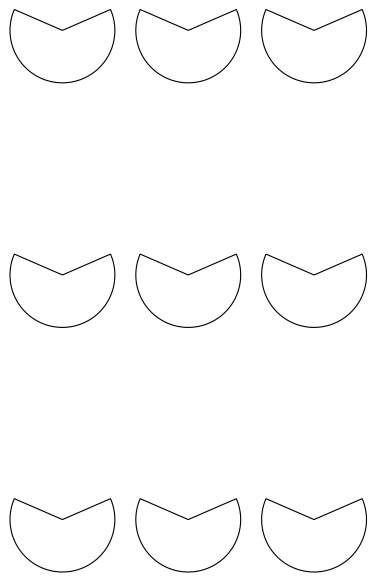

In [46]:
fg = id_events[var].plot.pcolormesh(
    x='lon', y='lat',
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.LambertConformal(
            central_longitude=10.0, central_latitude=60.6
        )
    },
    vmin=0.5,
    cmap='YlGnBu',
    col='time',
    col_wrap=3,
    robust=True,
    aspect=.4,
    cbar_kwargs={
        'orientation': 'horizontal',
        'pad': 0.01,
        'aspect': 40,
        'shrink': 0.8,
    },
)
fg.map(lambda: plt.gca().coastlines())

In [ ]:
# cluster.close()